In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import pickle
import sys
sys.path.insert(1, "../ipsc_gp_clustering")
from splitgpm import SplitGPM
from utils import gen_gsea_df
import gpflow.training.monitor as mon
import os
import matplotlib.pyplot as plt

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv

In [2]:
C=10
G=5000
T=10
K1=1
K2=20
N=C*T

In [3]:
X = np.loadtxt("../data/hep.X.txt")
Y = np.loadtxt("../data/hep.Y.txt")

In [4]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [5]:
gpflow.reset_default_graph_and_session()
name = 'test'
minibatch_size = 500
W1_init = normalize(np.random.random(size=(C, K1)))
W2_init = normalize(np.random.random(size=(G, K2)))

In [6]:
with gpflow.defer_build():
    kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
    Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
    feature = gpflow.features.InducingPoints(Z)
    feature = mf.SharedIndependentMof(feature)

    model = SplitGPM(X, Y, np.log(W1_init + 1e-5), np.log(W2_init + 1e-5), kernel, gpflow.likelihoods.Gaussian(), feat=feature, minibatch_size=minibatch_size, name=name)
model.compile()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Tensor("test/add_6:0", shape=(?, 20), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 20), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


In [7]:
model.W1.set_trainable(True)  # learn cell assignments
model.W2.set_trainable(True)  # learn gene assignments
model.feature.set_trainable(True)  # move inducing points
model.kern.set_trainable(True)  # learn kernel parameters
model.likelihood.set_trainable(True)  # learn likelihood parameters

In [8]:
adam = gpflow.train.AdamOptimizer(0.005)
adam.minimize(model, maxiter=10000)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [9]:
Xnew = np.linspace(0, 1, 100)[:, None]
mu, var = model.predict_f(Xnew)

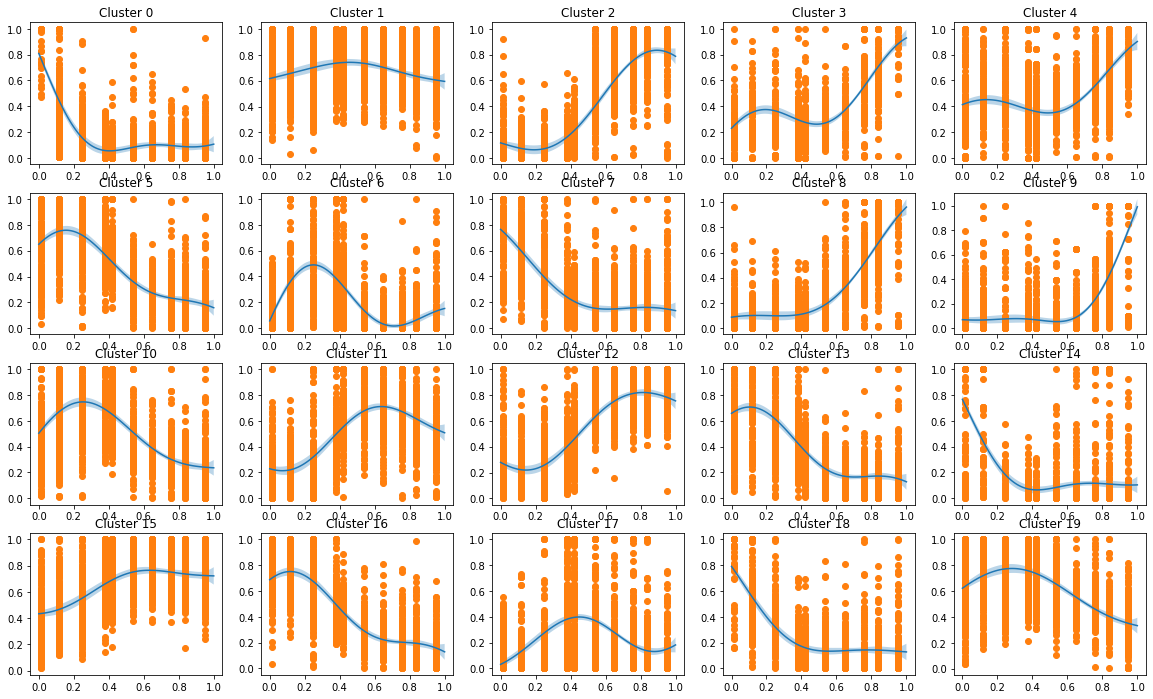

In [16]:
fig, ax = plt.subplots(4,5, figsize=(20,12))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[int(l/5), l%5].plot(Xnew, mu[:, l, k])
        ax[int(l/5), l%5].set_title("Cluster %d" % l)
        ax[int(l/5), l%5].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        
        assigned_points = np.logical_and(a1 == k, a2 == l)
        ax[int(l/5), l%5].scatter(X[assigned_points, 0], Y[assigned_points])

In [11]:
with open("../data/genedict.hep.pickle", 'rb') as f:
    genedict = pickle.load(f)
    f.close()

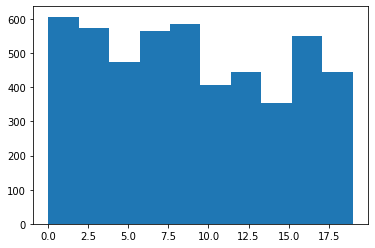

In [12]:
plt.hist(a2[:5000], bins=10)
plt.show()

In [13]:
assignments = model.W2.value.argmax(1)
gene_names = np.array(list(genedict.keys()))
results = gen_gsea_df(assignments, gene_names, 'gsea_output', threshold=1e-2, rerun=True)

In [14]:
idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[:, 'bonferonni-adjusted']]

,2,5,9,11,13,16
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,1,1,1,0.0018969,1,1
HALLMARK_MITOTIC_SPINDLE,1,0.506344,1,1,0.254964,0.000819162
HALLMARK_G2M_CHECKPOINT,1,7.47267e-07,1,1,0.00195236,3.1909e-15
HALLMARK_E2F_TARGETS,1,5.22805e-05,1,1,8.89749e-09,6.89533e-19
HALLMARK_MYC_TARGETS_V1,1,0.000203408,1,1,1,0.00288323
HALLMARK_COAGULATION,0.000390984,1,0.0048211,1,1,1
HALLMARK_BILE_ACID_METABOLISM,0.00793373,1,1,1,1,1
